In [6]:
import tensorflow as tf
import SimpleITK as sitk
import numpy as np
import pandas as pd

from tensorflow import keras
from dltk.io import preprocessing
from matplotlib import pyplot as plt

import os

In [130]:
description= pd.read_csv('ADNI_descrip.csv')

In [131]:
description.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I79080,136_S_1227,MCI,F,65,3,MRI,MPR; ; N3; Scaled,Processed,9/11/2007,NiFTI,NaN
1,I66824,136_S_1227,MCI,F,65,2,MRI,MPR; ; N3; Scaled,Processed,2/21/2007,NiFTI,7/28/2021
2,I99265,136_S_1227,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,3/06/2008,NiFTI,NaN
3,I83554,136_S_0579,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,6/25/2007,NiFTI,NaN
4,I119735,136_S_0579,MCI,F,66,2,MRI,MPR-R; ; N3; Scaled_2,Processed,7/10/2006,NiFTI,NaN


In [132]:
description = description.drop(columns= 'Downloaded', axis=1)

In [133]:
description.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format
0,I79080,136_S_1227,MCI,F,65,3,MRI,MPR; ; N3; Scaled,Processed,9/11/2007,NiFTI
1,I66824,136_S_1227,MCI,F,65,2,MRI,MPR; ; N3; Scaled,Processed,2/21/2007,NiFTI
2,I99265,136_S_1227,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,3/06/2008,NiFTI
3,I83554,136_S_0579,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,6/25/2007,NiFTI
4,I119735,136_S_0579,MCI,F,66,2,MRI,MPR-R; ; N3; Scaled_2,Processed,7/10/2006,NiFTI


In [199]:
description.isna().sum()

Image Data ID    0
Subject          0
Group            0
Sex              0
Age              0
Visit            0
Modality         0
Description      0
Type             0
Acq Date         0
Format           0
dtype: int64

Recursive Function to grab images
- add get image and the path

In [59]:
def check_file(file_path):
    dst = './data-folder'
    
    if file_path.endswith('nii'):
        shutil.copy(file_path, dst)
    
    else:
        sub_folders = os.listdir(file_path)
        for sub_folder in sub_folders:
            new_path = file_path + '/' + sub_folder
            check_file(new_path)

In [56]:
s.endswith('nii')

True

Image Visualization

In [62]:
image = './data-folder/ADNI_002_S_1268_MR_MPR-R____N3__Scaled_Br_20070806174712233_S27680_I65268.nii'

In [200]:
# load in sitk format
sitk_image = sitk.ReadImage(image)
# transform into a numpy array
img = sitk.GetArrayFromImage(sitk_image)
# check the final shape
img

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "./data-folder/ADNI_002_S_1268_MR_MPR-R____N3__Scaled_Br_20070806174712233_S27680_I65268.nii" does not exist.

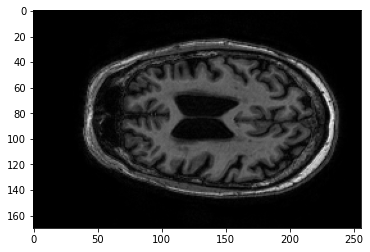

In [64]:
plt.imshow(img[:, :, 70], cmap='gray')
plt.show()

Trying to binarize the image using by applying OTSU's thresholding

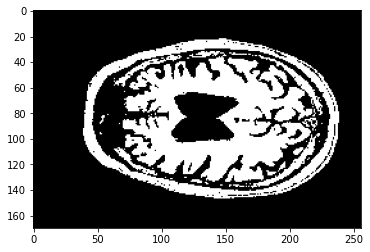

In [66]:
from skimage import filters
otsu = filters.threshold_otsu(img)
otsu_img = img > otsu
plt.imshow(otsu_img[:, :, 70], cmap='gray')
plt.show()

Trying out space normalization on one image just to get it working. Using a resampling method to get it going.

In [67]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' This function resamples images to 2-mm isotropic voxels.
      
        Parameters:
            itk_image -- Image in simpleitk format, not a numpy array
            out_spacing -- Space representation of each voxel
            
        Returns: 
            Resulting image in simpleitk format, not a numpy array
    '''
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [70]:
resample_img(sitk_image)

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002044649DDE0> >

C:\Users\Kamryn\anaconda3\lib\site-packages\dltk\io\preprocessing.py:87: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


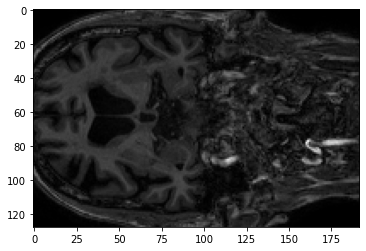

In [71]:
res = resample_img(sitk_image)
res_img = sitk.GetArrayFromImage(sitk_image)
res_img = preprocessing.resize_image_with_crop_or_pad(res_img, img_size=(128, 192, 192), mode='symmetric')
res_img = preprocessing.whitening(res_img)
plt.imshow(res_img[:, 100, :], cmap='gray')
plt.show()

Skull Stripping (just trying it out on one image)

In [74]:
from nipype.interfaces import fsl
import matplotlib.pyplot as plt

In [73]:
!pip install nipype

In [75]:
def skull_strip_nii(original_img, destination_img, frac=0.3):
    ''' Practice skull stripping on the given image, and save
        the result to a new .nii image.
        Uses FSL-BET 
        (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide#Main_bet2_options:)
        
        Parameters:
            original_img -- Original nii image
            destination_img -- The new skull-stripped image
            frac -- Fractional intensity threshold for BET
    '''
    
    btr = fsl.BET()
    btr.inputs.in_file = original_img
    btr.inputs.frac = frac
    btr.inputs.out_file = destination_img
    btr.cmdline
    res = btr.run()

Renaming the images by their patient ID to make them easier to grab.

In [78]:
def rename_image(folder):
    if (folder.endswith('.DS_Store') == False):
            images = os.listdir(folder)
            for image in images:
                name = image
                name_list = name.split('_')
                new_path = folder + '/' + name_list[-1]
                old_path = folder + '/' + image
                os.rename(old_path, new_path)



In [81]:
rename_image('./data-folder')

Making a new data frame that has  the subject id in correlation to each visit.

In [145]:
subjects = description['Subject'].tolist()

subject_unique = set(subjects)

df_3 = pd.DataFrame()

In [195]:
groups = description['Group'].tolist()

In [196]:
group_unique = set(groups)

In [ ]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
target_encoder.fit(df.diagnosis)
target = target_encoder.transform(df.diagnosis)

In [197]:
group_unique


{'AD', 'CN', 'MCI'}

In [148]:
df_3.head()

,subject
0,023_S_0855
1,005_S_0572
2,005_S_0602
3,027_S_1081
4,082_S_1256


In [146]:
df_3['subject'] = list(subject_unique)

In [161]:
description.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format
0,I79080,136_S_1227,MCI,F,65,3,MRI,MPR; ; N3; Scaled,Processed,9/11/2007,NiFTI
1,I66824,136_S_1227,MCI,F,65,2,MRI,MPR; ; N3; Scaled,Processed,2/21/2007,NiFTI
2,I99265,136_S_1227,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,3/06/2008,NiFTI
3,I83554,136_S_0579,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,6/25/2007,NiFTI
4,I119735,136_S_0579,MCI,F,66,2,MRI,MPR-R; ; N3; Scaled_2,Processed,7/10/2006,NiFTI


In [192]:
def get_visit3(groups):
    hold3= description.loc[(description['Subject'] == )&(description['Visit']==3)]
    hold4 = hold3.iloc[0]
    image_id = hold4['Image Data ID']
    return image_id

In [193]:
df_3['visit_3'] = df_3['subject'].apply(get_visit3)

IndexError: single positional indexer is out-of-bounds

In [194]:
def get_image(subject):
    path = 'Something/' + subject
    image = sitk.ReadImage(path)
    image = resample_img(image)
    return image

In [ ]:
get_image

In [158]:
df_3

,subject,visit_2
0,023_S_0855,I118987
1,005_S_0572,I32817
2,005_S_0602,I32762
3,027_S_1081,I47177
4,082_S_1256,I80880
...,...,...
114,018_S_0425,I139891
115,051_S_1072,I65662
116,012_S_1321,I73895
117,082_S_0928,I109533


In [137]:
df_2

,subject,visit_2,visit_3,visit_4,group
0,023_S_0855,I118987,I118987,I118987,MCI
1,005_S_0572,I32817,I32817,I32817,MCI
2,005_S_0602,I32762,I32762,I32762,MCI
3,027_S_1081,I47177,I47177,I47177,MCI
4,082_S_1256,I80880,I80880,I80880,MCI
...,...,...,...,...,...
114,018_S_0425,I139891,I139891,I139891,MCI
115,051_S_1072,I65662,I65662,I65662,MCI
116,012_S_1321,I73895,I73895,I73895,CN
117,082_S_0928,I109533,I109533,I109533,CN


In [140]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' This function resamples images to 2-mm isotropic voxels.
        Parameters:
            itk_image -- Image in simpleitk format, not a numpy array
            out_spacing -- Space representation of each voxel
        Returns:
            Resulting image in simpleitk format, not a numpy array
    '''
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(itk_image)

In [180]:
CN_FOLDER = 'CN'
MCI_FOLDER = 'MCI'
AD_FOLDER = 'AD'

In [189]:
description

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format
0,I79080,136_S_1227,MCI,F,65,3,MRI,MPR; ; N3; Scaled,Processed,9/11/2007,NiFTI
1,I66824,136_S_1227,MCI,F,65,2,MRI,MPR; ; N3; Scaled,Processed,2/21/2007,NiFTI
2,I99265,136_S_1227,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,3/06/2008,NiFTI
3,I83554,136_S_0579,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,6/25/2007,NiFTI
4,I119735,136_S_0579,MCI,F,66,2,MRI,MPR-R; ; N3; Scaled_2,Processed,7/10/2006,NiFTI
...,...,...,...,...,...,...,...,...,...,...,...
415,I45126,002_S_0559,CN,M,79,2,MRI,MPR; ; N3; Scaled,Processed,6/27/2006,NiFTI
416,I40657,002_S_0413,CN,F,76,2,MRI,MPR; ; N3; Scaled,Processed,5/19/2006,NiFTI
417,I128346,002_S_0413,CN,F,77,3,MRI,MPR; ; N3; Scaled_2,Processed,11/15/2006,NiFTI
418,I118675,002_S_0413,CN,F,76,2,MRI,MPR; ; N3; Scaled_2,Processed,5/19/2006,NiFTI


In [190]:
def process_and_upload(filename, path, skull_stripping=True, random_printing=False):
    ''' Process the image name and copy the image to its
        corresponding Google Drive folder.
        
        Parameters:
            filename -- Name of the image file (.nii)
            path -- The path were the image is located
            skull_stripping -- Whether or not to practice skull stripping
                               (The skull stripping method is defined in the
                               next section)
            random_priting -- 10% possibilities of printing a horizontal cut
                              useful to see if the skull stripping is working
                              as expected
    '''
    
    # separte the name of the file by '_'
    splitted_name = filename.strip().split('_')
    # sometimes residual MacOS files appear; ignore them
    if splitted_name[0] == '.': return
    
    # save the image ID
    image_ID = splitted_name[-1][1:-4]
    
    # sometimes empty files appear, just ignore them
    if image_ID == '': return
    # transform the ID into a int64 numpy variable for indexing
    image_ID = np.int64(image_ID)
        
    # with the ID, index the information we need
    row_index = description.index[description['Image Data ID'] == image_ID].tolist()[0]
    # obtain the corresponding row in the dataframe
    row = description.iloc[row_index]
    # get the label
    label = row['Group']
    
    #

In [198]:
process_and_upload('I101432.nii','./data-folder')

IndexError: list index out of range